## 1.数据整理

### 载入数据

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest

In [62]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [63]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  
train.info()
test.info()
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ 

### 整理数据

In [64]:
#首先整理test数据
#展现Open为nan的数据
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())
test['Date']=pd.to_datetime(test['Date'])

# 把date拆成year，month和day，重新设置DayOfWeek

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)

# print(test["StateHoliday"].value_counts())

test.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [65]:
#接着整理store数据

#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

print(store.query('CompetitionDistance=="NaN"'))
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879
store['CompetitionDistance']=store['CompetitionDistance'].fillna(0)
def f(x):
    return x-int(x)
print(store['CompetitionDistance'].apply(f).value_counts())
# 由于CompetitionDistance所有的小数部分都是0把CompetitionDistance转为int
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))
# 1115-354=761
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceYear']=0
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceMonth']=0

print(min(train['Date']))
print(min(test['Year']))
#训练值里最小的日期是2013-01-01，把没有开业时间的竞争对手店面开店时间随机设置到训练时间之前的随机年份和月份并且改为int型
random.seed(10)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(random.randint(2002,2012))
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(random.randint(1,12))
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

print(store['Promo2'].value_counts())
#571说明没有参与促销的商店是571
print(store['Promo2SinceWeek'].value_counts())
print(store['Promo2SinceYear'].value_counts())
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(0)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

store.info()


     Store  StoreType  Assortment  CompetitionDistance  \
290    291          4           1                  nan   
621    622          1           3                  nan   
878    879          4           1                  nan   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        nan                       nan       0   
621                        nan                       nan       0   
878                        nan                       nan       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              nan              nan              NaN  
621              nan              nan              NaN  
878            5.000         2013.000  Feb,May,Aug,Nov  
0.000    1115
Name: CompetitionDistance, dtype: int64
354
2013-01-01
2015
1    571
0    544
Name: Promo2, dtype: int64
14.000    81
40.000    77
31.000    44
10.000    42
5.000     39
37.000    35
1.000     35
45.000    34
13.000    34
22.000    33
18.000    29
35.0

In [66]:
#处理PromoInterval
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'1,4,7,10','Feb,May,Aug,Nov':'2,5,8,11','Mar,Jun,Sept,Dec':'3,6,9,12'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,1,1270,9,2008,0,0,0,"0,0,0,0"
1,2,1,1,570,11,2007,1,13,2010,"1,4,7,10"
2,3,1,1,14130,12,2006,1,14,2011,"1,4,7,10"
3,4,3,3,620,9,2009,0,0,0,"0,0,0,0"
4,5,1,1,29910,4,2015,0,0,0,"0,0,0,0"


In [67]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1)
store['PromoInterval2']=pd.Series(PromoInterval2)
store['PromoInterval3']=pd.Series(PromoInterval3)
store['PromoInterval4']=pd.Series(PromoInterval4)
        
store.info()            
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 14 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null int32
Assortment                   1115 non-null int32
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
PromoInterval1               1115 non-null object
PromoInterval2               1115 non-null object
PromoInterval3               1115 non-null object
PromoInterval4               1115 non-null object
dtypes: int32(7), int64(2), object(5)
memory usage: 91.5+ KB


In [68]:
# 将PromoInterval1，PromoInterval2，PromoInterval3，PromoInterval4列转为一个特征PromoIntervalMonth的不同值
store=store.melt(
id_vars=['Store','StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],   #要保留的主字段
var_name='PromoIntervalTemp',                     #拉长的分类变量
value_name="PromoIntervalMonth"         #拉长的度量值名称
)
print(store.info())
print(store.head())
print(store['PromoIntervalTemp'].value_counts())
store.drop('PromoIntervalTemp',axis=1, inplace=True)
store.drop('PromoInterval',axis=1, inplace=True)
store = store.drop_duplicates()
store['PromoIntervalMonth']=store['PromoIntervalMonth'].astype(int)
print(store.info())
print(store.head())
print(store['PromoIntervalMonth'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 12 columns):
Store                        4460 non-null int64
StoreType                    4460 non-null int32
Assortment                   4460 non-null int32
CompetitionDistance          4460 non-null int32
CompetitionOpenSinceMonth    4460 non-null int32
CompetitionOpenSinceYear     4460 non-null int32
Promo2                       4460 non-null int64
Promo2SinceWeek              4460 non-null int32
Promo2SinceYear              4460 non-null int32
PromoInterval                4460 non-null object
PromoIntervalTemp            4460 non-null object
PromoIntervalMonth           4460 non-null object
dtypes: int32(7), int64(2), object(3)
memory usage: 296.2+ KB
None
   Store  StoreType  Assortment  CompetitionDistance  \
0      1          3           1                 1270   
1      2          1           1                  570   
2      3          1           1                14130   
3      4   

In [69]:
#整理train数据
# print(train.info())
train['Date']=pd.to_datetime(train['Date'])

# 把date拆成year，month和day，重新设置DayOfWeek

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)


print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null int32
SchoolHoliday    1017209 non-null int64
Year             1017209 non-null int64
Month            1017209 non-null int64
Day              1017209 non-null int64
WeekOfYear       1017209 non-null int64
dtypes: int32(1), int64(11)
memory usage: 89.2 MB
None


### 合并数据

In [70]:
# 将train数据和store数据合并
train_store=pd.merge(train,store,how='inner',left_on=['Store'],right_on=['Store'])

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries, 0 to 2544742
Data columns (total 21 columns):
Store                        int64
DayOfWeek                    int64
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int32
SchoolHoliday                int64
Year                         int64
Month                        int64
Day                          int64
WeekOfYear                   int64
StoreType                    int32
Assortment                   int32
CompetitionDistance          int32
CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2                       int64
Promo2SinceWeek              int32
Promo2SinceYear              int32
PromoIntervalMonth           int32
dtypes: int32(9), int64(12)
memory usage: 339.8 MB


In [71]:
print(len(train_store.query('Promo2==0')[['Store','Year','Month','Day']]))
print(len(train_store.query('Promo2==0')[['Store','Year','Month','Day']].drop_duplicates()))
#给参加促销活动的数据去重
print(len(train_store.query('Promo2==1')[['Store','Year','Month','Day']]))
print(len(train_store.query('Promo2==1')[['Store','Year','Month','Day']].drop_duplicates()))

train_store=train_store.drop_duplicates()
print(len(train_store))

train_store['Promoing']=0

508031
508031
2036712
509178
2544743


In [72]:
#总数1017209
#开始清洗
#标记出正在参与Promo的记录
# train_store.query('Promo2==1 & PromoIntervalMonth==Month & ((Promo2SinceYear==Year & Promo2SinceWeek<=WeekOfYear) | (Promo2SinceYear<Year))')['Promoing']=1
train_store.loc[(train_store['Promo2']==1)&(train_store['PromoIntervalMonth']==train_store['Month'])&(((train_store['Promo2SinceYear']==train_store['Year'])&(train_store['Promo2SinceWeek']<=train_store['WeekOfYear']))|train_store['Promo2SinceYear']<train_store['Year']),'Promoing']=1
train_store['Promoing'].value_counts()

0    2369951
1     174792
Name: Promoing, dtype: int64

In [73]:
#去掉不必要的或者重复的特征
train_store.info()
train_store.drop('PromoIntervalMonth',axis=1, inplace=True)

train_store.drop('Promo2SinceWeek',axis=1, inplace=True)

train_store.drop('Promo2SinceYear',axis=1, inplace=True)

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries, 0 to 2544742
Data columns (total 22 columns):
Store                        int64
DayOfWeek                    int64
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int32
SchoolHoliday                int64
Year                         int64
Month                        int64
Day                          int64
WeekOfYear                   int64
StoreType                    int32
Assortment                   int32
CompetitionDistance          int32
CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2                       int64
Promo2SinceWeek              int32
Promo2SinceYear              int32
PromoIntervalMonth           int32
Promoing                     int64
dtypes: int32(9), int64(13)
memory usage: 359.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries,

In [74]:
#整理的目标总数为1017209
train_store=train_store.drop_duplicates()
print(len(train_store))

1192001


In [75]:
# 整理Promoing特征并去重
temp_train_store=train_store.query('Promoing==1')[['Store','Year','Month','Day','Promoing']]
train_store=train_store.drop('Promoing',axis=1).drop_duplicates()
train_store=pd.merge(train_store,temp_train_store,how='left',on=['Store','Year','Month','Day'])
train_store['Promoing']=train_store['Promoing'].fillna(0)
train_store['Promoing']=train_store['Promoing'].astype(int)
print(train_store.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null int32
SchoolHoliday                1017209 non-null int64
Year                         1017209 non-null int64
Month                        1017209 non-null int64
Day                          1017209 non-null int64
WeekOfYear                   1017209 non-null int64
StoreType                    1017209 non-null int32
Assortment                   1017209 non-null int32
CompetitionDistance          1017209 non-null int32
CompetitionOpenSinceMonth    1017209 non-null int32
CompetitionOpenSinceYear     1017209 non-null int32
Pro

In [76]:
#添加是否有竞争对手信息，然后删除竞争对手开始时间年/月
train_store['IsCompetition']=0
train_store.head()
train_store.loc[(train_store['CompetitionDistance']!=0)&((train_store['CompetitionOpenSinceYear']<train_store['Year'])|(train_store['CompetitionOpenSinceYear']==train_store['Year']&(train_store['CompetitionOpenSinceMonth']<=train_store['Month']))),'IsCompetition']=1
train_store['IsCompetition'].value_counts()
train_store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Sales                  1017209 non-null int64
Customers              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int32
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
StoreType              1017209 non-null int32
Assortment             1017209 non-null int32
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
dtypes: int32(5), int64(13)
memory usage: 128.1 MB


In [77]:
# 合并test
test_store=pd.merge(test,store,how='inner',left_on=['Store'],right_on=['Store'])
print(test.info())
print(test_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112656 entries, 0 to 112655
Data columns (total 20 columns):
Id                           112656 non-null int64
Store                        112656 non-null int64
DayOfWeek                    112656 non-null int64
Open                         112656 non-null int32
Promo                        112656 non-null int64
StateHoliday                 112656 non-null int32
Sch

In [78]:
test_store=test_store.drop_duplicates()
print(len(test_store))
test_store['Promoing']=0
#开始清洗
#标记出正在参与Promo的记录
# train_store.query('Promo2==1 & PromoIntervalMonth==Month & ((Promo2SinceYear==Year & Promo2SinceWeek<=WeekOfYear) | (Promo2SinceYear<Year))')['Promoing']=1
test_store.loc[(test_store['Promo2']==1)&(test_store['PromoIntervalMonth']==test_store['Month'])&(((test_store['Promo2SinceYear']==test_store['Year'])&(test_store['Promo2SinceWeek']<=test_store['WeekOfYear']))|test_store['Promo2SinceYear']<test_store['Year']),'Promoing']=1
test_store['Promoing'].value_counts()

test_store.drop(['PromoIntervalMonth','Promo2SinceWeek','Promo2SinceYear'],axis=1, inplace=True)

test_store.info()

112656
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112656 entries, 0 to 112655
Data columns (total 18 columns):
Id                           112656 non-null int64
Store                        112656 non-null int64
DayOfWeek                    112656 non-null int64
Open                         112656 non-null int32
Promo                        112656 non-null int64
StateHoliday                 112656 non-null int32
SchoolHoliday                112656 non-null int64
Year                         112656 non-null int64
Month                        112656 non-null int64
Day                          112656 non-null int64
WeekOfYear                   112656 non-null int64
StoreType                    112656 non-null int32
Assortment                   112656 non-null int32
CompetitionDistance          112656 non-null int32
CompetitionOpenSinceMonth    112656 non-null int32
CompetitionOpenSinceYear     112656 non-null int32
Promo2                       112656 non-null int64
Promoing       

In [79]:
test_store=test_store.drop_duplicates()
print(len(test_store))
#目标是整理出41088条记录

46324


In [80]:
# 依据Promoing特征来去重
temp_test_store=test_store.query('Promoing==1')[['Store','Year','Month','Day','Promoing']]
test_store=test_store.drop('Promoing',axis=1).drop_duplicates()
test_store=pd.merge(test_store,temp_test_store,how='left',on=['Store','Year','Month','Day'])
test_store['Promoing']=test_store['Promoing'].fillna(0)
print(len(test_store))

41088


In [81]:
#添加是否有竞争对手信息特征IsCompetition，然后删除竞争对手开始时间年/月
test_store['IsCompetition']=0
test_store.head()
test_store.loc[(test_store['CompetitionDistance']!=0)&((test_store['CompetitionOpenSinceYear']<test_store['Year'])|(test_store['CompetitionOpenSinceYear']==test_store['Year']&(test_store['CompetitionOpenSinceMonth']<=test_store['Month']))),'IsCompetition']=1
test_store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
test_store['Promoing']=test_store['Promoing'].astype(int)
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                     41088 non-null int64
Store                  41088 non-null int64
DayOfWeek              41088 non-null int64
Open                   41088 non-null int32
Promo                  41088 non-null int64
StateHoliday           41088 non-null int32
SchoolHoliday          41088 non-null int64
Year                   41088 non-null int64
Month                  41088 non-null int64
Day                    41088 non-null int64
WeekOfYear             41088 non-null int64
StoreType              41088 non-null int32
Assortment             41088 non-null int32
CompetitionDistance    41088 non-null int32
Promo2                 41088 non-null int64
Promoing               41088 non-null int32
IsCompetition          41088 non-null int64
dtypes: int32(6), int64(11)
memory usage: 4.7 MB


In [82]:
# 整理完成以后的train_store和test_store
test_store.info()
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                     41088 non-null int64
Store                  41088 non-null int64
DayOfWeek              41088 non-null int64
Open                   41088 non-null int32
Promo                  41088 non-null int64
StateHoliday           41088 non-null int32
SchoolHoliday          41088 non-null int64
Year                   41088 non-null int64
Month                  41088 non-null int64
Day                    41088 non-null int64
WeekOfYear             41088 non-null int64
StoreType              41088 non-null int32
Assortment             41088 non-null int32
CompetitionDistance    41088 non-null int32
Promo2                 41088 non-null int64
Promoing               41088 non-null int32
IsCompetition          41088 non-null int64
dtypes: int32(6), int64(11)
memory usage: 4.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (

In [83]:
train_store.isnull().any().any()
test_store.isnull().any().any()

False

## 数据探索

In [84]:
# 查看train_store
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Sales                  1017209 non-null int64
Customers              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int32
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
StoreType              1017209 non-null int32
Assortment             1017209 non-null int32
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
dtypes: int32(5), int64(13)
memory usage: 128.1 MB


In [85]:
#类别型的特征有StoreType，Assortment，


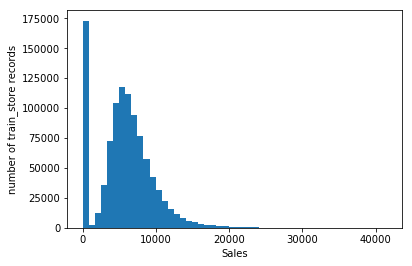

In [86]:
#值得分析的特征有，Sales,Customers,CompetitonDistance.
# Sales
plt.hist(train_store['Sales'].values, bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

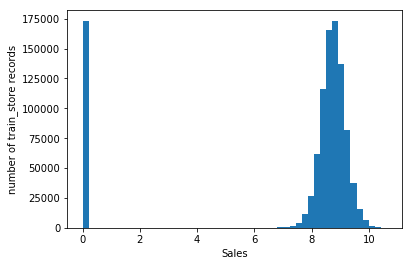

In [87]:
#正态化Sales
train_store['Sales']=(np.log1p(train_store['Sales']))
plt.hist(train_store['Sales'].values, bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

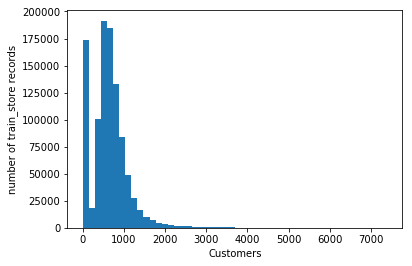

In [88]:
# Customers
plt.hist(train_store['Customers'].values, bins=50)  
plt.xlabel('Customers')  
plt.ylabel('number of train_store records')  
plt.show()

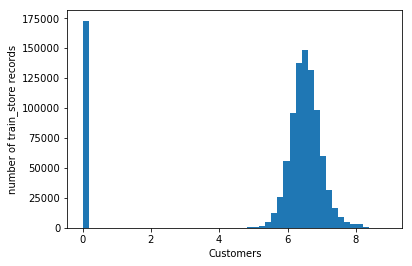

In [89]:
# 正态化Customer
train_store['Customers']=(np.log1p(train_store['Customers']))
plt.hist(train_store['Customers'].values, bins=50)  
plt.xlabel('Customers')  
plt.ylabel('number of train_store records')  
plt.show()

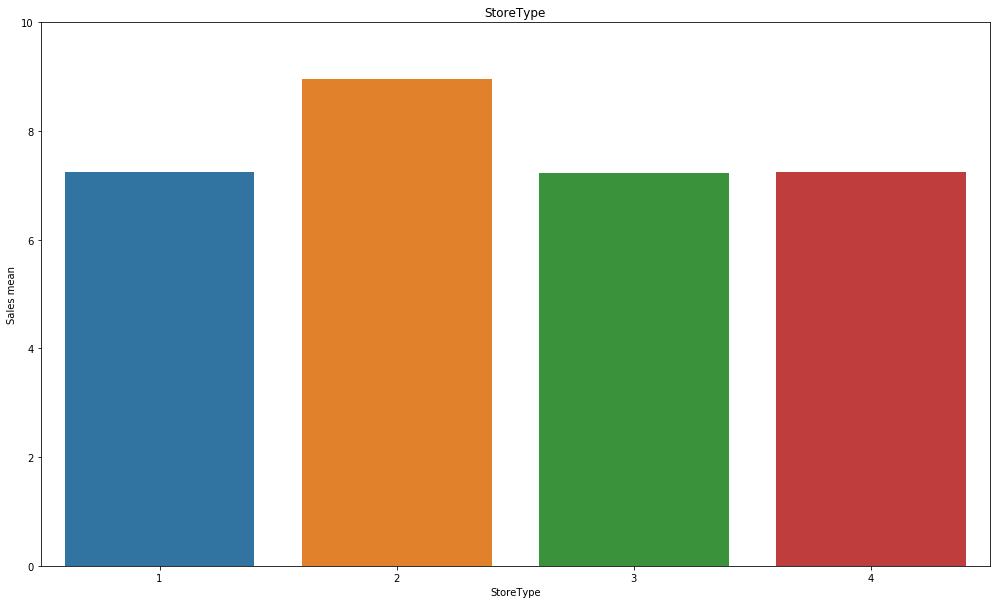

In [90]:
pt = train_store.groupby('StoreType')['Sales'].mean()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=10)  
plt.title('StoreType')  
plt.ylabel('Sales mean')  
sns.barplot(pt.index,pt.values)
plt.show()

In [91]:
# oneHot处理StoreType
pdtemp=pd.get_dummies(train_store['StoreType'],prefix='StoreType')
train_store= pd.concat([train_store,pdtemp], axis=1)
train_store.drop('StoreType',axis=1, inplace=True)
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,Assortment,CompetitionDistance,Promo2,Promoing,IsCompetition,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,1,4,8.569,6.321,1,1,0,1,2015,7,...,31,1,1270,0,0,1,0,0,1,0
1,1,3,8.521,6.304,1,1,0,1,2015,7,...,31,1,1270,0,0,1,0,0,1,0
2,1,2,8.473,6.261,1,1,0,1,2015,7,...,31,1,1270,0,0,1,0,0,1,0
3,1,1,8.520,6.330,1,1,0,1,2015,7,...,31,1,1270,0,0,1,0,0,1,0
4,1,0,8.717,6.418,1,1,0,1,2015,7,...,31,1,1270,0,0,1,0,0,1,0


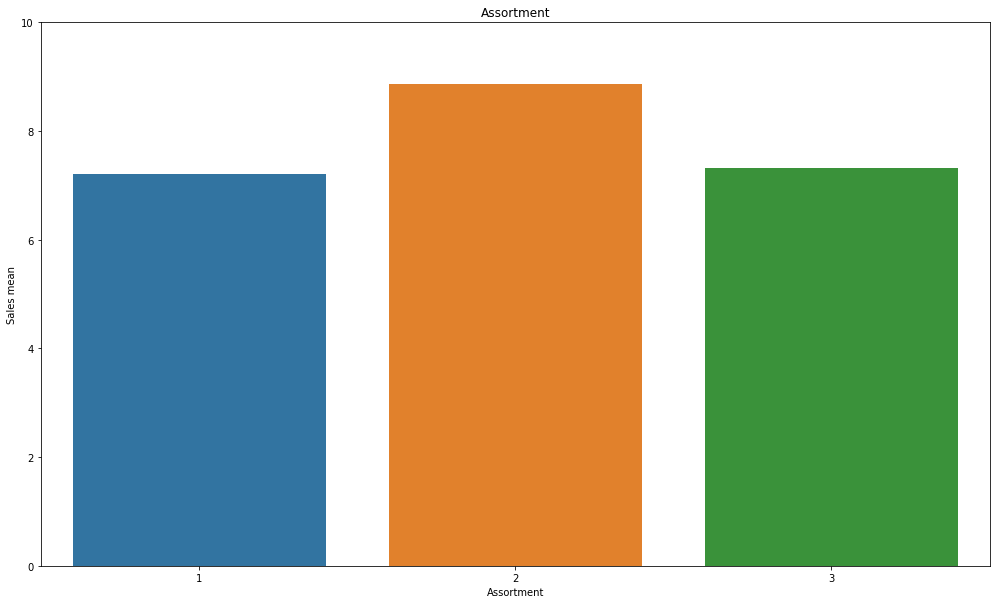

In [92]:
pa = train_store.groupby('Assortment')['Sales'].mean()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=10)  
plt.title('Assortment')  
plt.ylabel('Sales mean')  
sns.barplot(pa.index,pa.values)
plt.show()

In [93]:
# oneHot处理Assortment
train_store= pd.concat([train_store,pd.get_dummies(train_store['Assortment'],prefix='Assortment')], axis=1)
train_store.drop('Assortment',axis=1, inplace=True)
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Promo2,Promoing,IsCompetition,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3
0,1,4,8.569,6.321,1,1,0,1,2015,7,...,0,0,1,0,0,1,0,1,0,0
1,1,3,8.521,6.304,1,1,0,1,2015,7,...,0,0,1,0,0,1,0,1,0,0
2,1,2,8.473,6.261,1,1,0,1,2015,7,...,0,0,1,0,0,1,0,1,0,0
3,1,1,8.520,6.330,1,1,0,1,2015,7,...,0,0,1,0,0,1,0,1,0,0
4,1,0,8.717,6.418,1,1,0,1,2015,7,...,0,0,1,0,0,1,0,1,0,0


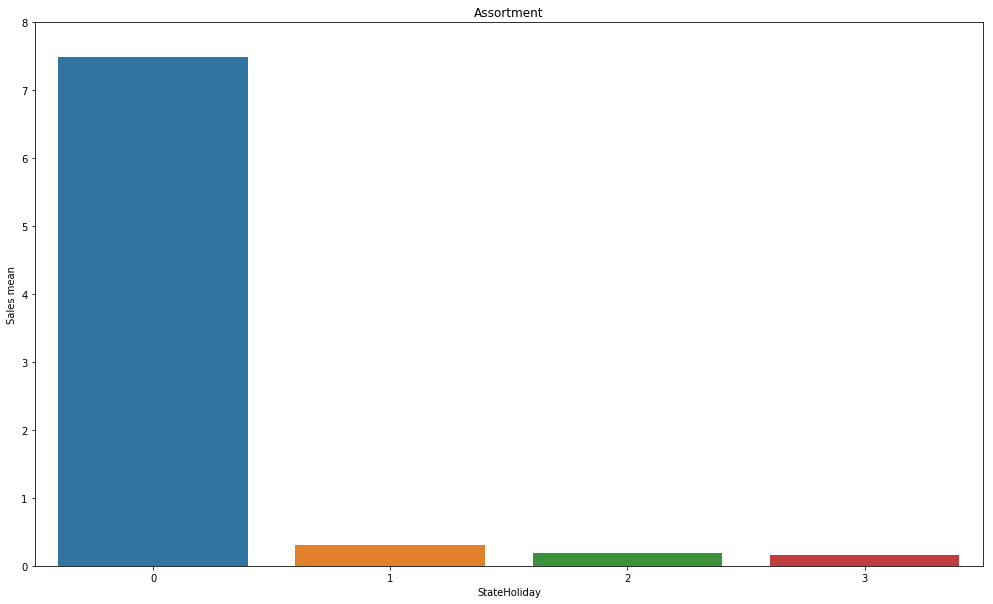

In [94]:
ph = train_store.groupby('StateHoliday')['Sales'].mean()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=8)  
plt.title('Assortment')  
plt.ylabel('Sales mean')  
sns.barplot(ph.index,ph.values)
plt.show()

In [95]:
# oneHot处理Assortment
train_store= pd.concat([train_store,pd.get_dummies(train_store['StateHoliday'],prefix='StateHoliday')], axis=1)
train_store.drop('StateHoliday',axis=1, inplace=True)
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,...,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3
0,1,4,8.569,6.321,1,1,1,2015,7,31,...,0,1,0,1,0,0,1,0,0,0
1,1,3,8.521,6.304,1,1,1,2015,7,30,...,0,1,0,1,0,0,1,0,0,0
2,1,2,8.473,6.261,1,1,1,2015,7,29,...,0,1,0,1,0,0,1,0,0,0
3,1,1,8.520,6.330,1,1,1,2015,7,28,...,0,1,0,1,0,0,1,0,0,0
4,1,0,8.717,6.418,1,1,1,2015,7,27,...,0,1,0,1,0,0,1,0,0,0


In [96]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 26 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Sales                  1017209 non-null float64
Customers              1017209 non-null float64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
StoreType_1            1017209 non-null uint8
StoreType_2            1017209 non-null uint8
StoreType_3            1017209 non-null uint8
StoreType_4            1017209 non-null uint8
Assortmen

In [124]:

def plot_feature_scores(x, y, names=None):  
  
    if not names:  
        names = range(len(x[0]))  
  
  
    # 1. 使用 sklearn.feature_selection.SelectKBest 给特征打分  
    slct = SelectKBest(k="all")  
    slct.fit(x, y)  
    scores = slct.scores_  
  
    # 2. 将特征按分数 从大到小 排序  
    named_scores = zip(names, scores)  
    sorted_named_scores = sorted(named_scores, key=lambda z: z[1], reverse=True)  
  
    sorted_scores = [each[1] for each in sorted_named_scores]  
    sorted_names = [each[0] for each in sorted_named_scores]  
  
    y_pos = np.arange(len(names))           # 从上而下的绘图顺序  
  
    # 3. 绘图  
      
    fig, ax =plt.subplots(1,1,figsize=(17,10))  
    ax.barh(y_pos, sorted_scores, height=0.7, align='center', color='#AAAAAA', tick_label=sorted_names)  
    # ax.set_yticklabels(sorted_names)      # 也可以在这里设置 条条 的标签~  
    ax.set_yticks(y_pos)  
    ax.set_xlabel('Feature Score')  
    ax.set_ylabel('Feature Name')  
    ax.invert_yaxis()  
    ax.set_title('F_classif scores of the features.')  
  
    # 4. 添加每个 条条 的数字标签  
    for score, pos in zip(sorted_scores, y_pos):  
        ax.text(score + 20, pos, '%.1f' % score, ha='center', va='bottom', fontsize=12)  
  
    plt.show()  

In [125]:
train_data=train_store.drop(['Sales'],axis=1)
train_target=train_store['Sales']
x_names = ["Store", "DayOfWeek","Customers","Open","Promo","SchoolHoliday","Year","Month","Day","WeekOfYear","CompetitionDistance","Promo2","Promoing","IsCompetition","StoreType_1","StoreType_2","StoreType_3","StoreType_4","Assortment_1","Assortment_2","Assortment_3","StateHoliday_0","StateHoliday_1","StateHoliday_2","StateHoliday_3"]  

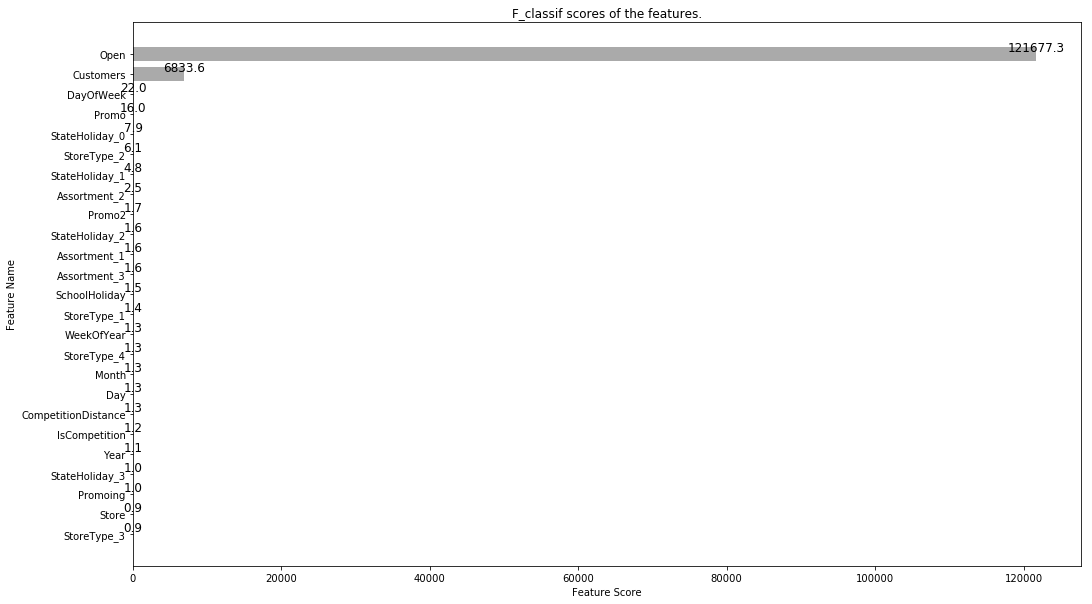

In [126]:
plot_feature_scores(train_data,train_target,x_names)

In [130]:
#store值无效去掉后再比较
train_data=train_data.drop(['Store'],axis=1)

In [131]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [132]:
# 检查测试数据
X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.4, random_state=0)
dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))
dvalid = xgb.DMatrix(X_test, np.log(y_test + 1))
dtest = xgb.DMatrix(test)

In [133]:
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 12,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 2000

In [134]:
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:1.30614	eval-rmse:1.30623	train-rmspe:0.770117	eval-rmspe:0.770194
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:1.04498	eval-rmse:1.04506	train-rmspe:0.689561	eval-rmspe:0.689629
[2]	train-rmse:0.836171	eval-rmse:0.836228	train-rmspe:0.606403	eval-rmspe:0.606461
[3]	train-rmse:0.66915	eval-rmse:0.669201	train-rmspe:0.524871	eval-rmspe:0.524922
[4]	train-rmse:0.535581	eval-rmse:0.535625	train-rmspe:0.448111	eval-rmspe:0.448154
[5]	train-rmse:0.428586	eval-rmse:0.428626	train-rmspe:0.378152	eval-rmspe:0.37819
[6]	train-rmse:0.343166	eval-rmse:0.343203	train-rmspe:0.316056	eval-rmspe:0.316089
[7]	train-rmse:0.274907	eval-rmse:0.274942	train-rmspe:0.262098	eval-rmspe:0.262125
[8]	train-rmse:0.220122	eval-rmse:0.220162	train-rmspe:0.215897	eval-rmspe:0.215922
[9]	train-rmse:0.176538	eval-rmse:0.176582	train-rmspe:0.177034	eval-rmspe:0.177054
[10]	train-rmse:0.14

[96]	train-rmse:0.005654	eval-rmse:0.006764	train-rmspe:0.006287	eval-rmspe:0.00718
[97]	train-rmse:0.00562	eval-rmse:0.006739	train-rmspe:0.006249	eval-rmspe:0.007153
[98]	train-rmse:0.005586	eval-rmse:0.00672	train-rmspe:0.006211	eval-rmspe:0.00713
[99]	train-rmse:0.00556	eval-rmse:0.0067	train-rmspe:0.006183	eval-rmspe:0.007107
[100]	train-rmse:0.005543	eval-rmse:0.006699	train-rmspe:0.006163	eval-rmspe:0.007106
[101]	train-rmse:0.005507	eval-rmse:0.006677	train-rmspe:0.006123	eval-rmspe:0.00708
[102]	train-rmse:0.005487	eval-rmse:0.006667	train-rmspe:0.006101	eval-rmspe:0.007068
[103]	train-rmse:0.005463	eval-rmse:0.006647	train-rmspe:0.006073	eval-rmspe:0.007045
[104]	train-rmse:0.005455	eval-rmse:0.006645	train-rmspe:0.006065	eval-rmspe:0.007043
[105]	train-rmse:0.005427	eval-rmse:0.006621	train-rmspe:0.006033	eval-rmspe:0.007015
[106]	train-rmse:0.005393	eval-rmse:0.0066	train-rmspe:0.005995	eval-rmspe:0.00699
[107]	train-rmse:0.005362	eval-rmse:0.006578	train-rmspe:0.005962	eva

[192]	train-rmse:0.004397	eval-rmse:0.006182	train-rmspe:0.004892	eval-rmspe:0.006521
[193]	train-rmse:0.004389	eval-rmse:0.00618	train-rmspe:0.004883	eval-rmspe:0.006523
[194]	train-rmse:0.004387	eval-rmse:0.00618	train-rmspe:0.004881	eval-rmspe:0.006522
[195]	train-rmse:0.004384	eval-rmse:0.006179	train-rmspe:0.004878	eval-rmspe:0.006522
[196]	train-rmse:0.004379	eval-rmse:0.00618	train-rmspe:0.004872	eval-rmspe:0.006522
[197]	train-rmse:0.004361	eval-rmse:0.006173	train-rmspe:0.004853	eval-rmspe:0.006514
[198]	train-rmse:0.004353	eval-rmse:0.006173	train-rmspe:0.004843	eval-rmspe:0.006515
[199]	train-rmse:0.00434	eval-rmse:0.006169	train-rmspe:0.004829	eval-rmspe:0.00651
[200]	train-rmse:0.004332	eval-rmse:0.006168	train-rmspe:0.00482	eval-rmspe:0.006509
[201]	train-rmse:0.004326	eval-rmse:0.006168	train-rmspe:0.004813	eval-rmspe:0.006509
[202]	train-rmse:0.004322	eval-rmse:0.006167	train-rmspe:0.004808	eval-rmspe:0.006508
[203]	train-rmse:0.004316	eval-rmse:0.006168	train-rmspe:0.0

[288]	train-rmse:0.003712	eval-rmse:0.006089	train-rmspe:0.00413	eval-rmspe:0.006419
[289]	train-rmse:0.003702	eval-rmse:0.006088	train-rmspe:0.004119	eval-rmspe:0.006417
[290]	train-rmse:0.003694	eval-rmse:0.006089	train-rmspe:0.00411	eval-rmspe:0.006418
[291]	train-rmse:0.003691	eval-rmse:0.006087	train-rmspe:0.004107	eval-rmspe:0.006417
[292]	train-rmse:0.003684	eval-rmse:0.006088	train-rmspe:0.004099	eval-rmspe:0.006418
[293]	train-rmse:0.003678	eval-rmse:0.006089	train-rmspe:0.004092	eval-rmspe:0.006419
[294]	train-rmse:0.003672	eval-rmse:0.00609	train-rmspe:0.004086	eval-rmspe:0.00642
[295]	train-rmse:0.003665	eval-rmse:0.006088	train-rmspe:0.004078	eval-rmspe:0.006418
[296]	train-rmse:0.003661	eval-rmse:0.006089	train-rmspe:0.004073	eval-rmspe:0.006419
[297]	train-rmse:0.003654	eval-rmse:0.00609	train-rmspe:0.004066	eval-rmspe:0.00642
[298]	train-rmse:0.003649	eval-rmse:0.00609	train-rmspe:0.00406	eval-rmspe:0.00642
[299]	train-rmse:0.003648	eval-rmse:0.00609	train-rmspe:0.00405

[384]	train-rmse:0.003233	eval-rmse:0.006076	train-rmspe:0.003596	eval-rmspe:0.006406
[385]	train-rmse:0.00323	eval-rmse:0.006077	train-rmspe:0.003592	eval-rmspe:0.006407
[386]	train-rmse:0.003229	eval-rmse:0.006077	train-rmspe:0.003591	eval-rmspe:0.006407
[387]	train-rmse:0.003224	eval-rmse:0.006077	train-rmspe:0.003586	eval-rmspe:0.006407
[388]	train-rmse:0.003218	eval-rmse:0.006077	train-rmspe:0.00358	eval-rmspe:0.006407
[389]	train-rmse:0.003215	eval-rmse:0.006077	train-rmspe:0.003576	eval-rmspe:0.006407
[390]	train-rmse:0.003209	eval-rmse:0.006077	train-rmspe:0.003569	eval-rmspe:0.006407
[391]	train-rmse:0.003205	eval-rmse:0.006078	train-rmspe:0.003564	eval-rmspe:0.006408
[392]	train-rmse:0.003201	eval-rmse:0.006078	train-rmspe:0.00356	eval-rmspe:0.006408
[393]	train-rmse:0.003195	eval-rmse:0.006078	train-rmspe:0.003553	eval-rmspe:0.006408
[394]	train-rmse:0.003191	eval-rmse:0.006078	train-rmspe:0.003549	eval-rmspe:0.006409
[395]	train-rmse:0.003187	eval-rmse:0.006078	train-rmspe:

In [29]:
# 切割x和y


# X_train=X_train.as_matrix()
# X_test=X_test.as_matrix()

In [30]:

gbm1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
predictions_test=gbm.predict(X_test)

In [35]:
# def rmspe(y, yhat):
#     return np.sqrt(np.mean((yhat/y-1) ** 2))
# np.log1p(X_valid.Sales)
print(np.expm1(predictions_test))

[ inf  inf  inf ...,  inf  inf  inf]


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in expm1
  after removing the cwd from sys.path.


In [33]:
error = rmspe(y_test.values, np.expm1(predictions_test))
print('RMSPE: {:.6f}'.format(error))

NameError: name 'rmspe' is not defined

In [64]:
print(predictions_test)
error = rmspe(np.exp(predictions_test) - 1, y_test.values)
print('error', error)

[ 3823.72436523  7105.19628906  6492.51904297 ...,  8516.38867188
  6126.64501953  5398.74462891]
error nan


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


In [43]:
# submission = pd.DataFrame({'Id': test['Id'],
#                             'Sales': predictions})
# print(submission)
# submission.to_csv("submission.csv",index=False)


          Id        Sales
0          1   292.636566
1          2   204.852600
2          3   638.279968
3          4   638.279968
4          5   184.572479
5          6   184.572479
6          7   184.572479
7          8   184.572479
8          9   168.790024
9         10   168.790024
10        11   168.790024
11        12   184.572479
12        13   236.286469
13        14   701.281372
14        15   701.281372
15        16   739.727661
16        17   739.727661
17        18  1011.719849
18        19   533.091797
19        20   457.074402
20        21   312.416504
21        22   292.313629
22        23   159.091782
23        24   159.091782
24        25   159.091782
25        26   174.874237
26        27   174.874237
27        28   644.364136
28        29   644.364136
29        30   628.581726
...      ...          ...
41058  41059   817.333374
41059  41060   835.933716
41060  41061   741.516785
41061  41062   721.413879
41062  41063   669.740845
41063  41064   669.740845
41064  41065

### 检查正确率

### 处理数据

In [118]:
#看看有没有open为0但是有销售数据的
new_train.query('Open==0 & Sales>0')
#看看销售数据的情况
new_train["Sales"].describe()
# 看看节假日有哪些
new_train["StateHoliday"].drop_duplicates()
#各个StateHolitday的数据值类型 
new_train["StateHoliday"].value_counts()

NameError: name 'new_train' is not defined

In [11]:
new_train.query('Open==0 & Sales>0')
new_train.query('Open==1 & StateHoliday=="c"')['Date'].value_counts()

12/26/2013    19
12/26/2014    19
12/25/2013    17
12/25/2014    16
Name: Date, dtype: int64

In [12]:
new_train.query('Open==0 & SchoolHoliday=="1"')[['Date','Store']]

new_train.query('Store==1')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,7/31/2015,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,7/30/2015,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,7/29/2015,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,7/28/2015,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,7/27/2015,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
5,1,7,7/26/2015,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
6,1,6,7/25/2015,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
7,1,5,7/24/2015,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
8,1,4,7/23/2015,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
9,1,3,7/22/2015,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [13]:
#根据常识我觉得客户数和销售量的关系应该很大
#添加一个月份
t=new_train['Date'].str.split('/')
month=[]

for m in t: 
    month.append(m[0])

new_train['Month']=pd.to_numeric(pd.Series(month))

new_train.info()

new_train['Month'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null f

5     103695
3     103695
1     103694
6     100350
4     100350
7      98115
2      93660
12     63550
10     63550
8      63550
11     61500
9      61500
Name: Month, dtype: int64

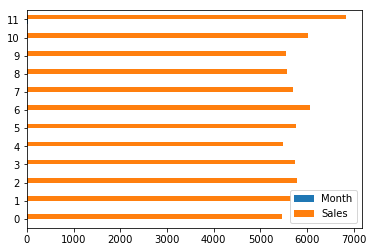

In [46]:
# 按月份sum销售额
new_train[['Month','Sales']].groupby('Month',as_index=False).mean().sort_values('Month')
month_sales=new_train[['Month','Sales']].groupby('Month',as_index=False).mean().sort_values('Month')
month_sales.plot(kind='barh',rot=0)
plt.show()

In [43]:
data_counts=new_train['Date'].value_counts()
print(len(data_counts))
# data_counts.plot(kind='barh',rot=0)
# plt.show()

942


### 单变量分析

TypeError: unhashable type: 'slice'

### 测试xgboost模型

In [15]:
model = XGBClassifier()